- https://arxiv.org/abs/2309.17453

In [6]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import List, Tuple
from tqdm.notebook import tqdm
import seaborn as sns

In [48]:
def generate_sentences(n=256):
    """Generate n sentences of specified token length"""
    # Simple sentence templates to ensure meaningful content
    templates = [
        "The {} {} {} in the {}.",
        "{} {} {} near the {}.",
        "A {} {} {} through the {}.",
        "Some {} {} {} beside the {}."
    ]
    
    # Word lists for filling templates
    adjectives = ["big", "small", "red", "blue", "fast", "slow", "bright", "dark"]
    nouns = ["cat", "dog", "bird", "tree", "car", "house", "book", "phone"]
    verbs = ["runs", "jumps", "sits", "moves", "falls", "flies", "walks", "stands"]
    locations = ["garden", "park", "room", "street", "forest", "beach", "field", "yard"]
    
    sentences = []
    for _ in range(n):
        template = np.random.choice(templates)
        sentence = template.format(
            np.random.choice(adjectives),
            np.random.choice(nouns),
            np.random.choice(verbs),
            np.random.choice(locations)
        )
        sentences.append(sentence)
    
    return sentences

In [43]:
def get_attention_maps(model, tokenizer, sentences):
    """Extract attention maps for given sentences"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    attention_maps = []
    max_length = max(len(tokenizer.encode(s)) for s in sentences)
    tokenizer.pad_token = tokenizer.eos_token
    for sentence in tqdm(sentences, desc="Processing sentences"):
        inputs = tokenizer(sentence, 
                           padding='max_length', 
                           max_length=max_length, 
                           return_tensors="pt", truncation=True
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
        
        # Get attention tensors from all layers
        attentions = outputs.attentions
        # print(len(attentions), attentions[0].shape)
        # Convert to numpy and average across heads
        layer_attentions = [att[0].mean(dim=0).cpu().numpy() for att in attentions]
        attention_maps.append(layer_attentions)
    
    return attention_maps

In [15]:
def plot_attention_maps(attention_maps, save_path="attention_maps.png"):
    """Plot attention maps for selected layers"""
    # Average across all sentences
    avg_attention = []
    for layer in range(len(attention_maps[0])):
        layer_attention = np.mean([maps[layer] for maps in attention_maps], axis=0)
        avg_attention.append(layer_attention)
    
    # Select layers to visualize (first 2 layers and some higher layers)
    layers_to_plot = [0, 1, 2, 9, 16, 23, 31]
    n_plots = len(layers_to_plot)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for idx, layer_idx in enumerate(layers_to_plot):
        ax = axes[idx]
        sns.heatmap(avg_attention[layer_idx], 
                   cmap="RdBu_r",
                   ax=ax,
                   cbar=True)
        ax.set_title(f"Layer {layer_idx} Head 0")
        ax.set_xlabel("")
        ax.set_ylabel("")
    
    # Remove the last empty subplot
    axes[-1].remove()
    
    plt.tight_layout()
    # plt.savefig(save_path, dpi=300, bbox_inches='tight')

In [21]:
model_name = "meta-llama/Meta-Llama-3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    attn_implementation="eager"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

We've detected an older driver with an RTX 4000 series GPU. These drivers have issues with P2P. This can affect the multi-gpu inference when using accelerate device_map.Please make sure to update your driver to the latest version which resolves this.


In [49]:
sentences = generate_sentences(n=256)

In [56]:
att_maps = get_attention_maps(model, tokenizer, sentences)
# att_logit_maps = get_attention_logits(model, tokenizer, sentences)

Processing sentences:   0%|          | 0/256 [00:00<?, ?it/s]

Processing sentences:   0%|          | 0/256 [00:00<?, ?it/s]

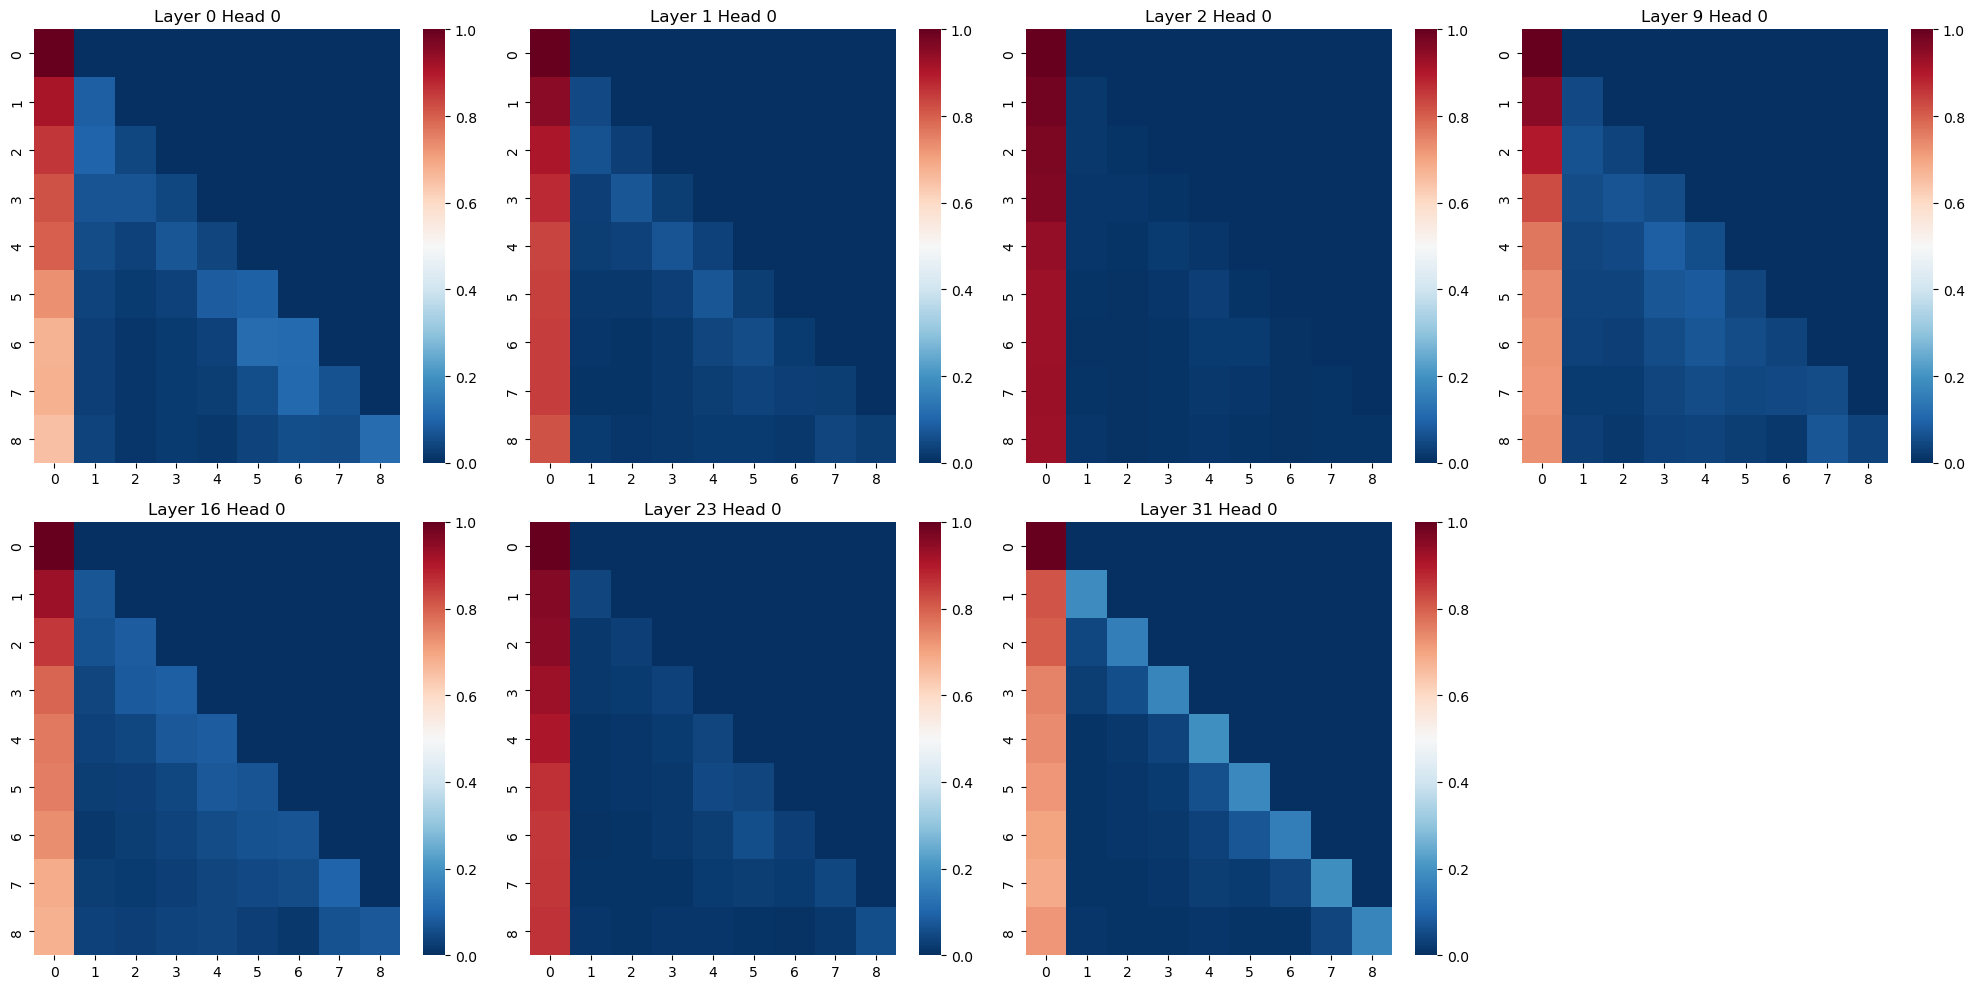

In [47]:
# 绘制可视化图
plot_attention_maps(attention_maps)